In [80]:
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random
import math

In [63]:
data = pd.read_csv('diabetes.csv')
# Nowy plik, bo KNN mocno mieli, więc wolę testować osobno puszczając cały plik

In [64]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [78]:
# Klasa statyczna zawierająca metody przydatne to przetwarzania danych
class ProcessingData:

    # metoda tasująca wiersze pd.DataFrame
    @staticmethod
    def shuffle(df: pd.DataFrame) -> pd.DataFrame:
        """
        Receives a DataFrame, randomly shuffles it and returns a shuffled version.
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        for idx in range(len(df) - 1, 0, -1):
            rand_idx = random.randint(0, idx)
            df.iloc[idx], df.iloc[rand_idx] = df.iloc[rand_idx], df.iloc[idx]
        return df

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji z użyciem odchylenia standardowego
    @staticmethod
    def normalize_std(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.mean())/(normalized.std())
        return normalized.join(df[label])

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji minmax
    @staticmethod
    def normalize_minmax(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.min())/(normalized.max()-normalized.min())
        return normalized.join(df[label])

    # metoda dzieląca pd.DataFrame na zbiór treningowy oraz walidacyjny
    @staticmethod
    def split(df: pd.DataFrame, ratio: float) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Receives a DataFrame and returns two dataframes, split into training and validation DataFrames.
        :param df: pd.DataFrame
        :param ratio: float
        :return training_df, validation_df: tuple[pd.DataFrame, pd.DataFrame]
        """
        cutoff = int(len(df) * ratio)
        return df[:cutoff].reset_index(drop=True), df[cutoff:].reset_index(drop=True)

In [140]:
shuffled_data = ProcessingData.shuffle(data)
training_data, validation_data = ProcessingData.split(shuffled_data, 0.7)

In [138]:
# Klasyfikator zbiorów rozmytych
"""
Normy:
Pregnancies:
-
Glucose:
- 70-99 prawidlowe
- 100-125 ryzyko
- 126+ cukrzyca
BloodPressure:
- <80 prawidlowe
- 80-89 podwyzszone faza 1
- >90 podwyszone faza 2
SkinThickness:
- mediana 25 mm
Insulin:
- <30
Age:
- ryzyko od 45 r.ż.
"""

'\nNormy:\nPregnancies:\n-\nGlucose:\n- 70-99 prawidlowe\n- 100-125 ryzyko\n- 126+ cukrzyca\nBloodPressure:\n- <80 prawidlowe\n- 80-89 podwyzszone faza 1\n- >90 podwyszone faza 2\nSkinThickness:\n- mediana 25 mm\nInsulin:\n- <30\nAge:\n- ryzyko od 45 r.ż.\n'

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64

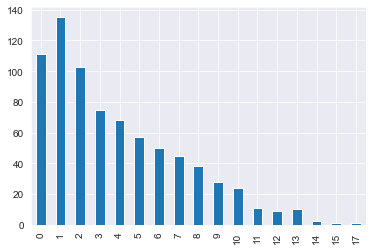

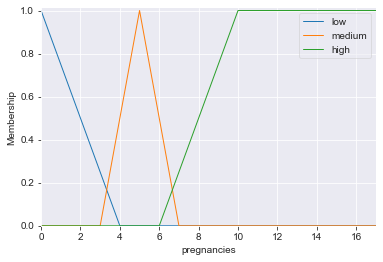

In [141]:
pregnancies_data = data['Pregnancies']
pregnancies_data.value_counts().sort_index().plot.bar(sort_columns=True)
pregnancies = ctrl.Antecedent(pregnancies_data.sort_values(), 'pregnancies')
pregnancies['low'] = fuzz.trimf(pregnancies.universe, [0, 0, 4])
pregnancies['medium'] = fuzz.trimf(pregnancies.universe, [3, 5, 7])
pregnancies['high'] = fuzz.trapmf(pregnancies.universe, [6, 10, 17, 17])
pregnancies.view()
pregnancies_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    763.000000
mean     121.686763
std       30.535641
min       44.000000
25%       99.000000
50%      117.000000
75%      141.000000
max      199.000000
Name: Glucose, dtype: float64

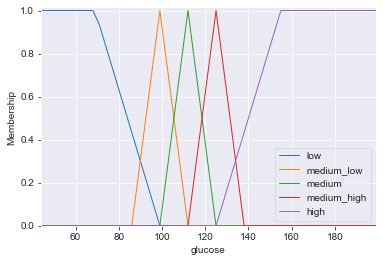

In [143]:
glucose_data = data['Glucose']
glucose_data = glucose_data[glucose_data != 0]
glucose = ctrl.Antecedent(glucose_data.sort_values(), 'glucose')
glucose['low'] = fuzz.trapmf(glucose.universe, [44, 44, 69, 99])
glucose['medium_low'] = fuzz.trimf(glucose.universe, [86, 99, 112])
glucose['medium'] = fuzz.trimf(glucose.universe, [99, 112, 125])
glucose['medium_high'] = fuzz.trimf(glucose.universe, [112, 125, 138])
glucose['high'] = fuzz.trapmf(glucose.universe, [125, 155, 199, 199])
glucose.view()
glucose_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    733.000000
mean      72.405184
std       12.382158
min       24.000000
25%       64.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

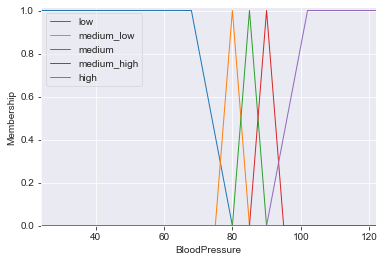

In [145]:
bloodpressure_data = data['BloodPressure']
bloodpressure_data = bloodpressure_data[bloodpressure_data != 0]
bloodpressure = ctrl.Antecedent(bloodpressure_data.sort_values(), 'BloodPressure')
bloodpressure['low'] = fuzz.trapmf(bloodpressure.universe, [24, 24, 68, 80])
bloodpressure['medium_low'] = fuzz.trimf(bloodpressure.universe, [75, 80, 85])
bloodpressure['medium'] = fuzz.trimf(bloodpressure.universe, [80, 85, 90])
bloodpressure['medium_high'] = fuzz.trimf(bloodpressure.universe, [85, 90, 95])
bloodpressure['high'] = fuzz.trapmf(bloodpressure.universe, [90, 102, 122, 122])
bloodpressure.view()
bloodpressure_data.describe()